# Predictive Model w/ Segmentation

## Setup

In [160]:
import pandas as pd
import pysam
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import sqlite3
import csv
import glob
import gffpandas.gffpandas as gffpd
from intervaltree import Interval, IntervalTree
import bisect
from tqdm import tqdm
from biomart import BiomartServer
import os
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
from gseapy import GSEA
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from scipy.stats import kruskal, mannwhitneyu, ttest_ind, f_oneway, wilcoxon, ranksums, fisher_exact, chi2_contingency, entropy, pearsonr
import json
import ast
import itertools
import sys
from venn import venn
import contextlib
from imblearn.over_sampling import SMOTE
from upsetplot import from_contents, plot
import warnings
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import shap
import pyranges as pr

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import DBSCAN

### Helper Functions

In [161]:
def assert_column(df, column_name, df_name=''):
        assert column_name in df.columns, f"'{column_name}' column is missing in {df_name}"
        assert not df[column_name].isnull().all(), f"'{column_name}' column is empty in {df_name}"

In [162]:
def cpg2segment_aggregation_trees(cpg_df, segment_df):

    dataframes = {'cpg_df': ['source_directory', 'sample_id_adj', 'chrom'],
                'segment_df': ['start', 'end', 'segment_id', 'chrom', 'gene_symbol', 'length']}

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    # Filter out chromosomes from cpg_df that aren't in segment_df
    cpg_df = cpg_df[cpg_df['chrom'].isin(segment_df['chrom'].unique())]

    # Create an IntervalTree for each group
    segment_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) 
                     for seq_id, group in segment_df.groupby('chrom')}
    
    print("initializing meth_seg...")

    # Initialize meth_seg DataFrame
    meth_seg = pd.DataFrame(list(itertools.product(cpg_df["sample_id_adj"].unique(), 
                                                   segment_df["segment_id"].unique())),
                            columns=['sample_id_adj', 'segment_id'])
    
    meth_seg = meth_seg.merge(cpg_df[['sample_id_adj', 'source_directory']].drop_duplicates(), on='sample_id_adj', how='left')

    meth_seg = meth_seg.sort_values(['sample_id_adj']).reset_index(drop=True)
    meth_seg["total_methylation"] = 0.0
    meth_seg["positions"] = [[] for _ in range(len(meth_seg))]
    meth_seg["mod_qual_positions"] = [[] for _ in range(len(meth_seg))]
    meth_seg["num_cpgs"] = 0

    # Initialize a dictionary to store the rows
    meth_seg_dict = {(row.segment_id, row.sample_id_adj, row.source_directory): row for _, row in meth_seg.iterrows()}

    # Group the DataFrame by 'source_directory', 'sample_id_adj', and 'chrom'
    grouped = cpg_df.groupby(['source_directory', 'sample_id_adj', 'chrom'])

    for (source_directory, sample_id_adj, chrom), group in tqdm(grouped, desc="Aggregating"):
        tree = segment_trees[chrom]
        for row in group.itertuples():
            intervals = tree[row.ref_position]
            for interval in intervals:
                # Use the dictionary for lookup and update
                key = (interval.data, sample_id_adj, source_directory)
                meth_seg_row = meth_seg_dict[key]
                meth_seg_row.total_methylation += row.mod_qual
                meth_seg_row.num_cpgs += 1  # Increment the number of CpGs for this segment
                meth_seg_row.positions.append(row.ref_position)
                meth_seg_row.mod_qual_positions.append(row.mod_qual)

    # Convert the dictionary back to a DataFrame
    meth_seg = pd.DataFrame(meth_seg_dict.values())

    # Calculate the average of the values in the 'mod_quals_positions' column
    meth_seg['avg_methylation'] = meth_seg['mod_qual_positions'].apply(lambda x: np.mean(x) if x else 0)

    meth_seg = meth_seg.merge(segment_df[['segment_id', 'gene_symbol', 'length', 'chrom']], on='segment_id', how='left').sort_values("segment_id")

    # Convert the lists to strings
    meth_seg['positions'] = meth_seg['positions'].astype(str)
    meth_seg['mod_qual_positions'] = meth_seg['mod_qual_positions'].astype(str)

    # Now you can safely drop duplicates
    meth_seg = meth_seg.drop_duplicates().reset_index(drop=True)

    return meth_seg

In [163]:
def create_fm(meth_seg, metadata):
    dataframes = {
        'meth_seg': ['segment_id', 'source_directory', 'sample_id_adj', 'avg_methylation'],
        'metadata': ['source_directory', 'sample_id_adj', 'Group']
    }

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    meth_seg_pivot = meth_seg.pivot_table(index=["sample_id_adj", "source_directory"], columns="segment_id", values="avg_methylation").reset_index()
    # Fill missing values with zeros
    meth_seg_pivot = meth_seg_pivot.fillna(0)
    meth_seg_fm = meth_seg_pivot.merge(metadata[["sample_id_adj", "Group", "tumor_type"]], on = "sample_id_adj", how = "left").drop_duplicates().reset_index(drop = True)
    # Assuming 'Group' is the column you want to move to the front
    group = meth_seg_fm.pop('Group')
    meth_seg_fm.insert(0, 'Group', group)
    meth_seg_fm.sort_values("source_directory", inplace = True)

    # Remove all zero columns
    meth_seg_fm = meth_seg_fm.loc[:, (meth_seg_fm != 0).any(axis=0)]

    return meth_seg_fm

In [164]:
def pca_plot(df, n_components=2, group_column=None, label_column=None):

    # Perform PCA
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(df.select_dtypes(exclude=['object']))

    # Create a DataFrame with the principal components
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    # Add the 'Group' column back to the DataFrame
    principalDf["group"] = df[group_column]

    # If label_column is provided, use it as label
    if label_column:
        principalDf["label"] = df[label_column]
    else:
        principalDf["label"] = df[group_column]

    # Create a scatter plot
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1, Explained variance: {:.2%}'.format(pca.explained_variance_ratio_[0]), fontsize = 15)
    ax.set_ylabel('Principal Component 2, Explained variance: {:.2%}'.format(pca.explained_variance_ratio_[1]), fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    groups = principalDf["group"].unique()
    colors = ['r', 'g', 'b', 'y']  # Add more colors if you have more groups

    for group, color in zip(groups, colors):
        indicesToKeep = principalDf["group"] == group
        scatter = ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
        
        # Add labels to the data points
        for i in range(len(principalDf.loc[indicesToKeep, 'principal component 1'])):
            ax.text(principalDf.loc[indicesToKeep, 'principal component 1'].values[i], principalDf.loc[indicesToKeep, 'principal component 2'].values[i], principalDf.loc[indicesToKeep, 'label'].values[i])
    
    # Add legend for colors
    ax.legend(groups)
    ax.grid()

    plt.show()

In [165]:
def tm_pcc(meth_seg, metadata, DEG_full, pcc_file):

    dataframes = {
        'meth_seg': ['segment_id', 'source_directory', 'sample_id_adj', 'positions', 'mod_qual_positions', 'avg_methylation'],
        'metadata': ['source_directory', 'sample_id_adj', 'sample_id_adj_rnaseq'],
        'DEG_full': ['gene_symbol']
    }

    for df_name, columns in dataframes.items():
        for column in columns:
            assert_column(eval(df_name), column, df_name)

    sample_id_adj_rnaseq = metadata[metadata["source_directory"].isin(meth_seg["source_directory"].unique())]["sample_id_adj_rnaseq"]

    # Melt the DataFrame
    DEG_full_longer = DEG_full.melt(id_vars=['gene_symbol'], value_vars=sample_id_adj_rnaseq, var_name='sample_id_adj', value_name='counts')

    tm_df = meth_seg.merge(DEG_full_longer, on = ["gene_symbol", "sample_id_adj"], how = "left").dropna()
    tm_df["log2_counts"] = np.log2(tm_df["counts"] + 1)

    correlation, p_value = pearsonr(tm_df['avg_methylation'], tm_df['log2_counts'])

    print(f"Average methylation - log2counts pearson correlation: {correlation}")
    print(f"p-value: {p_value}")

    correlation, p_value = pearsonr(tm_df['total_methylation'], tm_df['log2_counts'])

    print(f"Total methylation - log2counts pearson correlation: {correlation}")
    print(f"p-value: {p_value}")

    # Calculate Pearson correlation for each gene
    correlations = []
    for gene in tm_df['gene_symbol'].unique():
        df_gene = tm_df[tm_df['gene_symbol'] == gene]
        if df_gene['avg_methylation'].nunique() > 1 and df_gene['log2_counts'].nunique() > 1:
            correlation, p_value = pearsonr(df_gene['avg_methylation'], df_gene['log2_counts'])
        else:
            correlation, p_value = np.nan, np.nan
        correlations.append((gene, correlation, p_value))

    # Convert to DataFrame and sort by correlation
    correlations_df = pd.DataFrame(correlations, columns=['gene_symbol', 'correlation', 'p_value'])

    # Correct p-values for multiple comparisons
    # reject, pvals_corrected, _, _ = multipletests(correlations_df['p_value'], method='fdr_bh')
    # correlations_df['p_value_corrected'] = pvals_corrected
    
    correlations_df = correlations_df.sort_values('p_value', ascending=True).dropna()

    # Save to file
    correlations_df.to_csv(pcc_file, index=False)

    return correlations_df

In [166]:
def plot_correlation_distribution(correlations_df):
    plt.figure(figsize=(10, 5))
    plt.hist(correlations_df['correlation'], bins=30, edgecolor='black')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.title('Distribution of Correlations')
    plt.show()

In [167]:
def process_wgbs_seg_files(folder):
    """
    Function to process .tsv files in a folder and save the result to a .csv file.

    Parameters:
    folder (str): The folder containing the .tsv files.
    output_file (str): The path to the output .csv file.
    """
    # Find all .tsv files in the folder
    file_paths = glob.glob(folder + '/**/*.tsv', recursive=True)

    # Read each file into a DataFrame and append it to the list, skipping empty files
    dfs = []
    for i, file_path in enumerate(file_paths):
        try:
            df = pd.read_csv(file_path, sep='\t')
            # Drop columns that are empty or all NA
            df = df.dropna(how='all', axis=1)
            dfs.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file_path}")

    # Concatenate all DataFrames in the list
    df_concat = pd.concat(dfs, ignore_index=True)

    # Rename columns with multiple periods to the substring before the first period
    df_concat = df_concat.rename(columns=lambda x: x.split('.')[0] if '.' in x else x)

    df_concat["segment_id"] = df_concat["chr"].astype(str) + ":" + df_concat["start"].astype(str) + "-" + df_concat["end"].astype(str)

    df_concat = df_concat.rename(columns={'chr': 'chrom'})

    return df_concat

In [168]:
def process_wgbs_dmr_files(folder):
    """
    Function to process .bed files in a folder and return a DataFrame.

    Parameters:
    folder (str): The folder containing the .bed files.

    Returns:
    pandas.DataFrame: The resulting DataFrame.
    """
    # Find all .bed files in the folder
    file_paths = glob.glob(folder + '/**/*.bed', recursive=True)

    # Read each file into a DataFrame and append it to the list, skipping empty files
    dfs = []
    for i, file_path in enumerate(file_paths):
        try:
            df = pd.read_csv(file_path, sep='\t')
            # Drop columns that are empty or all NA
            df = df.dropna(how='all', axis=1)
            dfs.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file_path}")

    # Concatenate all DataFrames in the list
    df_concat = pd.concat(dfs, ignore_index=True)

    df_concat = df_concat.rename(columns={'#chr': 'chrom', 'region': 'segment_id'})

    # Add an empty 'gene_symbol' column
    df_concat['gene_symbol'] = "none"

    df_concat["length"] = df_concat["end"] - df_concat["start"]

    return df_concat

In [169]:
def filter_dmr(X_train_df, X_test_df, groups_train, test = 'ttest', p_value_threshold=0.05):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)

        # Keep a copy of the column names
        column_names = X_train_df.columns

        # Convert the data to numpy arrays for faster computation
        X_train = X_train_df.values
        X_test = X_test_df.values
        groups_train = groups_train.values

        # Get the indices of the 'R' and 'S' groups
        R_indices = np.where(groups_train == 'R')[0]
        S_indices = np.where(groups_train == 'S')[0]

        # Split the data into the 'R' and 'S' groups
        R_data = X_train[R_indices]
        S_data = X_train[S_indices]

        # Calculate the test statistic and p-value for all columns at once
        if test == 'ttest':
            test_statistic, p_values = ttest_ind(R_data, S_data, axis=0, nan_policy='omit')
        elif test == 'kruskal':
            p_values = np.empty(X_train.shape[1])
            for i in range(X_train.shape[1]):
                _, p_values[i] = kruskal(R_data[:, i], S_data[:, i], nan_policy='omit')
        else:
            raise ValueError("Invalid test. Only 'ttest' and 'kruskal' are supported.")

        # Correct for multiple testing
        corrected_p_values = multipletests(p_values, method='fdr_bh')[1]

        # Create a DataFrame with the p-values
        dmr_results = pd.DataFrame({
            'segment_id': column_names,
            'q_value': corrected_p_values,
            'p_value': p_values
        })

        # Filter the DataFrame based on the p-value threshold
        filtered_dmr = dmr_results[dmr_results['p_value'] <= p_value_threshold]

        # Keep only the columns in X_test and X_train that are in filtered_dmr
        X_test_filtered = X_test_df.filter(filtered_dmr['segment_id'])
        X_train_filtered = X_train_df.filter(filtered_dmr['segment_id'])

    return X_train_filtered, X_test_filtered, filtered_dmr

In [170]:
def plot_roc_curve(y_test, y_pred_proba):
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [171]:
def split(X, y, test_size):

    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, np.arange(len(X)), test_size=test_size)

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [233]:
def train_and_predict_single(meth_seg_fm, test_size = 0.25, train_indices=None, test_indices=None, reg = False, dmr = None, oversamp = None):
    # Initialize the encoder and scaler
    encoder = LabelEncoder()
    scaler = StandardScaler()

    X = meth_seg_fm.select_dtypes(exclude=['object'])
    y = meth_seg_fm["Group"]

    if train_indices is None and train_indices is None:
        X_train, X_test, y_train, y_test, train_indices, test_indices = split(X, y, test_size)
    else:
        if test_indices is None and train_indices is not None:
            test_indices = [i for i in range(len(X)) if i not in train_indices]
        elif train_indices is None and test_indices is not None:
            train_indices = [i for i in range(len(X)) if i not in test_indices]
        X_train, X_test, y_train, y_test = X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

    groups_train = meth_seg_fm["Group"].iloc[train_indices]
    groups_test = meth_seg_fm["Group"].iloc[test_indices]
    cell_lines_train = meth_seg_fm["sample_id_adj"].iloc[train_indices]
    cell_lines_test = meth_seg_fm["sample_id_adj"].iloc[test_indices]

    X_features_prev = X_train.columns
    X_features_current = X_features_prev

    if dmr:
        X_train, X_test, filtered_dmr = filter_dmr(X_train, X_test, groups_train, dmr)
        X_features_prev = X_features_current
        X_features_current = X_train.columns
        print(f"DMR has removed {len(X_features_prev)-len(X_features_current)} features of the original {len(X_features_prev)}.")

    # Convert the target variable to numeric values
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    # Standardize the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert back to dataframes
    X_train = pd.DataFrame(X_train, columns=X_features_current)
    X_test = pd.DataFrame(X_test, columns=X_features_current)

    # Fit the logistic regression model
    if reg:
        model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=10000)
    else:
        model = LogisticRegression()
    
    model.fit(X_train, y_train)

    # Assuming X is your feature matrix and model is your trained model
    X_features_prev = X_features_current
    X_features_current = X_features_current[model.coef_[0] != 0]

    if reg:
        print(f"Regularization has removed {len(X_features_prev)-len(X_features_current)} features of the original {len(X_features_prev)}.")

    # Get the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Get the predicted classes
    y_pred = model.predict(X_test)

    # Convert the predicted classes back to the original string labels
    y_pred_labels = encoder.inverse_transform(y_pred)

    class_names = model.classes_

    # Print the predicted labels and the true labels for each sample
    for i in range(len(X_test)):
        print("Sample:", i)
        print("Cell line:", cell_lines_test.iloc[i])
        print("True label:", encoder.inverse_transform([y_test[i]])[0])
        print("Predicted label:", y_pred_labels[i])
        print("Probabilities:")
        for j in range(len(class_names)):
            print(f"{encoder.inverse_transform([class_names[j]])}: {y_pred_proba[i, j]}")
        print()

    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    
    # Plot the SHAP values as a bar plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    if dmr or reg:
        # Use loc instead of iloc
        retained_features_fm = X.loc[:, X_features_current]
        retained_features_fm["sample_id_adj"] = meth_seg_fm["sample_id_adj"]
        retained_features_fm["Group"] = meth_seg_fm["Group"]
        print("PCA after filtering:")
        retained_features_fm.reset_index(drop=True, inplace=True)
        pca_plot(retained_features_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

    # Get the feature importances
    importances = model.coef_[0]

    # Create a DataFrame with the feature names and their corresponding importances
    importances_df = pd.DataFrame({'Feature': X_features_prev, 'Importance': importances})

    return model, X_train, X_test, importances_df, shap_values


In [173]:
def train_and_predict_loo(meth_seg_fm, reg = False, dmr = None):
    # Initialize the encoder, scaler and classifier
    encoder = LabelEncoder()
    scaler = StandardScaler()

    X = meth_seg_fm.select_dtypes(exclude=['object'])
    y = meth_seg_fm["Group"]
    
    # Fit the logistic regression model
    if reg:
        clf = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=10000)
    else:
        clf = LogisticRegression()

    loo = LeaveOneOut()
    accuracies = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if dmr:
            groups_train = meth_seg_fm["Group"].iloc[train_index]
            X_train, X_test, filtered_dmr = filter_dmr(X_train, X_test, groups_train, dmr)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = encoder.fit_transform(y_train)
        y_test = encoder.transform(y_test)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average accuracy: {average_accuracy}")

In [174]:
def plot_pvalue_distribution(pvalues):
    """
    Function to plot the distribution of p-values.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the p-values.
    pvalue_column (str): Name of the column in df that contains the p-values.
    """
    # Create a new figure
    sns.displot(pvalues, kde=False, bins=30)

    # Set the title and labels
    plt.title('P-value Distribution')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

### Data Import

#### Metadata

In [175]:
metadata = pd.read_csv("/data/lvisser/metadata/ont_metadata.csv", sep = ";")
print(metadata.shape)
metadata.head()

(48, 16)


,run_id_rnaseq,run_id_ont,source_directory,sample_id_ori,sample_id_adj,sample_id_adj_rnaseq,cell_line_long,cell_line_short,tumor_type,bio_replicate,Group,L,batch,gender,age (months),barcode
0,RIMR14nov_R3_EKRN230005052.1A_HNYCWDSX5_L1_norRNA,OHMX20230016R_002,data_OHMX20230016R_20231114,RIMR14nov_R3,IMR14nov_R1,IMR14nov_R1,IMR-32,IMR,NB,1,S,L1,14/11/2024,male,13.0,barcode02
1,RIMR21nov_R3_EKRN230005053.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR21nov_R3,IMR21nov_R2,NaN,IMR-32,IMR,NB,2,S,L1,21/11/2024,male,13.0,NaN
2,RIMR12dec_R3_EKRN230005054.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR12dec_R3,IMR12dec_R3,NaN,IMR-32,IMR,NB,3,S,L1,12/12/2024,male,13.0,NaN
3,RIMR15dec_R3_EKRN230005055.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RIMR15dec_R3,IMR15dec_R4,NaN,IMR-32,IMR,NB,4,S,L1,15/12/2024,male,13.0,NaN
4,RSHP14nov_R1_EKRN230005048.1A_HNYCWDSX5_L1_norRNA,NaN,NaN,RSHP14nov_R1,SHP14nov_R1,NaN,SH-EP,SHP,NB,1,S,L1,14/11/2024,female,48.0,NaN


#### Gene Whitelist

In [176]:
whitelist = pd.read_csv("/data/lvisser/ferroptosis_gene_whitelists/complete_gene_list_no_duplicates.txt", index_col = 0)
whitelist.columns = ["gene_symbol"]
print(whitelist.shape)
whitelist.head()

(1271, 1)


,gene_symbol
1,NR4A1
2,NR4A2
3,NR4A3
4,ACACA
5,ACLY


#### DE Genes

In [177]:
DEG_full = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_full.csv")
DEG_full = DEG_full[DEG_full["padj"] < 0.05]
DEG_full = DEG_full.rename(columns = {DEG_full.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_full.shape)
DEG_full.head()

(8488, 51)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
6191,ENSG00000268895,109.118613,1.231726,0.705169,2.781499e-03,0.014594,198.323394,91.560461,165.733760,149.289871,...,64.677340,147.940128,124.847573,63.303751,144.163675,132.674599,84.841380,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
1837,ENSG00000128274,186.925118,-4.550350,1.181914,1.108199e-06,0.000020,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
4357,ENSG00000242908,8.323454,-3.936345,2.903493,4.346391e-04,0.003240,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...
1568,ENSG00000129673,25.946025,-1.413103,0.318514,3.030699e-07,0.000006,95.933177,6.104031,17.187205,10.587934,...,5.215914,3.735862,2.496951,10.550625,4.219425,2.567895,5.953781,AANAT,protein_coding,aralkylamine N-acetyltransferase [Source:HGNC ...
1479,ENSG00000008311,818.446853,-1.918062,0.400305,2.025127e-07,0.000004,1191.785231,79.352400,214.840059,4884.214022,...,126.225131,279.442464,342.082349,136.103064,341.070157,273.908850,167.450093,AASS,protein_coding,aminoadipate-semialdehyde synthase [Source:HGN...


In [178]:
DEG_MM = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_MM.csv")
DEG_MM = DEG_MM[DEG_MM["padj"] < 0.05]
DEG_MM = DEG_MM.rename(columns = {DEG_MM.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_MM.shape)
DEG_MM.head()

(10513, 25)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,RPMI8226_1_3b,JJN3_1_3b,OPM_4_1,MM1R_1_2,...,MM1R_3_1,MM1R_2_2,RPMI8226_2_3b,JJN3_2_2b,JJN3_3_3b,RPMI8226_3_2b,MM1R_4_2,gene_symbol,type,description
1400,ENSG00000121410,7.014971,5.552054,0.881142,3.236431e-11,6.644271e-10,30.772996,4.387573,0.000000,0.727842,...,0.000000,0.000000,4.439469,19.874979,18.699434,10.235900,0.000000,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
179,ENSG00000268895,53.074171,8.849115,0.774549,3.377764e-32,5.397292e-30,121.553335,73.711227,0.000000,0.000000,...,0.000000,0.000000,71.031509,177.284812,113.009624,79.693789,0.000000,A1BG-AS1,lncRNA,A1BG antisense RNA 1 [Source:HGNC Symbol;Acc:H...
8748,ENSG00000148584,4.744162,1.489638,0.896618,6.471468e-03,2.127470e-02,0.769325,6.142602,1.625325,0.000000,...,5.721027,0.823753,16.648010,3.974996,4.878113,21.934070,1.828777,A1CF,protein_coding,APOBEC1 complementation factor [Source:HGNC Sy...
9793,ENSG00000175899,2.744737,-1.904452,1.547904,1.234374e-02,3.624637e-02,0.000000,0.000000,0.812662,9.461943,...,17.163082,9.885031,0.000000,3.179997,0.000000,0.000000,1.828777,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
8567,ENSG00000128274,196.668642,2.250318,1.534502,5.737457e-03,1.926012e-02,748.553130,7.897631,0.000000,53.132449,...,75.326858,46.953897,9.988806,704.369253,703.261329,12.429307,47.548195,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."


In [179]:
DEG_NB = pd.read_csv("/data/lvisser/DE_genes/DE_results_human_Group_R_S_NB.csv")
DEG_NB = DEG_NB[DEG_NB["padj"] < 0.05]
DEG_NB = DEG_NB.rename(columns = {DEG_NB.columns[0]: "Gene", "name": "gene_symbol"}).reset_index(drop = True).sort_values("gene_symbol")
print(DEG_NB.shape)
DEG_NB.head()

(8362, 35)


,Gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,IMR14nov_R1,SHY2sept_R1,SKN10nov_R1,SHP14nov_R1,...,SH-SY5Y_C1,SH-SY5Y_J2,SH-SY5Y_J4,SH-SY5Y_C4,SH-SY5Y_J3,SH-SY5Y_J1,SH-SY5Y_C3,gene_symbol,type,description
5338,ENSG00000121410,43.403148,-0.703134,0.282696,1.270573e-03,7.467374e-03,99.622914,20.346769,33.146752,41.292943,...,13.561378,38.105791,26.217990,18.991125,42.194246,29.958781,33.490019,A1BG,protein_coding,alpha-1-B glycoprotein [Source:HGNC Symbol;Acc...
3589,ENSG00000175899,10.902600,2.421982,0.806641,9.738070e-05,8.514165e-04,5.534606,18.312092,1.227657,1.058793,...,33.381853,23.162343,11.236282,13.715813,21.800361,20.543164,32.745796,A2M,protein_coding,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:...
6417,ENSG00000256069,3.489697,1.528053,0.946759,3.738377e-03,1.828207e-02,0.000000,3.052015,1.227657,4.235174,...,1.043183,2.241517,4.993903,6.330375,5.625899,5.991756,4.465336,A2MP1,transcribed_unprocessed_pseudogene,alpha-2-macroglobulin pseudogene 1 [Source:HGN...
841,ENSG00000128274,180.929104,-7.278222,1.117654,3.352751e-12,1.246874e-10,0.922434,0.000000,3.682972,1154.084822,...,1.043183,0.000000,0.000000,0.000000,0.000000,2.567895,0.000000,A4GALT,protein_coding,"alpha 1,4-galactosyltransferase (P blood group..."
5986,ENSG00000242908,13.445579,-3.317788,2.683701,2.529103e-03,1.325931e-02,0.000000,0.000000,0.000000,95.291407,...,0.000000,0.000000,0.000000,1.055063,0.000000,0.855965,0.000000,AADACL2-AS1,lncRNA,AADACL2 antisense RNA 1 [Source:HGNC Symbol;Ac...


## Segmentations

### Promotor Regions (Ensembl Regulatory Features GFF)

In [180]:
gff_file = "/data/lvisser/Ensembl/homo_sapiens.GRCh38.Regulatory_Build.regulatory_features.20210107.gff"

rf = gffpd.read_gff3(gff_file)
rf_df = pd.DataFrame(rf.df)

subattributes = rf_df['attributes'].str.split(';', expand=True)

for i in range(subattributes.shape[1]):
    subattribute = subattributes[i].str.split('=', expand=True)
    rf_df[subattribute[0].iloc[0]] = subattribute[1]

rf_df = rf_df.drop('attributes', axis = 1)

rf_df.to_csv('segmentations/all_rf_grch38.csv', index=False)
rf_df.head()

/home/lvisser/miniforge3/envs/jupyterNB/lib/python3.10/site-packages/gffpandas/gffpandas.py:32: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_table(self._gff_file, comment='#',


,seq_id,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type
0,GL000008.2,Regulatory_Build,open_chromatin_region,103733,104006,.,.,.,open_chromatin_region:ENSR00000898744,104006,103733,Open chromatin region,Open chromatin
1,GL000008.2,Regulatory_Build,open_chromatin_region,106249,106503,.,.,.,open_chromatin_region:ENSR00000898745,106503,106249,Open chromatin region,Open chromatin
2,GL000008.2,Regulatory_Build,open_chromatin_region,112878,113287,.,.,.,open_chromatin_region:ENSR00000898746,113287,112878,Open chromatin region,Open chromatin
3,GL000008.2,Regulatory_Build,open_chromatin_region,134012,134308,.,.,.,open_chromatin_region:ENSR00000898747,134308,134012,Open chromatin region,Open chromatin
4,GL000008.2,Regulatory_Build,open_chromatin_region,138112,138274,.,.,.,open_chromatin_region:ENSR00001290160,138274,138112,Open chromatin region,Open chromatin


In [181]:
grch38 = pd.read_csv('/data/lvisser/Ensembl/GRCh38.tsv', sep='\t', header = None)
grch38.columns = ["chrom", "total_length(bp)", "GenBank_accession", "RefSeq_accession"]
grch38.head()

,chrom,total_length(bp),GenBank_accession,RefSeq_accession
0,1,"248,956,422",CM000663.2,NC_000001.11
1,2,"242,193,529",CM000664.2,NC_000002.12
2,3,"198,295,559",CM000665.2,NC_000003.12
3,4,"190,214,555",CM000666.2,NC_000004.12
4,5,"181,538,259",CM000667.2,NC_000005.10


In [182]:
# Replace 'file.sga' with the path to your SGA file
epd_df = pd.read_csv('/data/lvisser/EPD/Hs_EPDnew.sga', sep='\t')
epd_df.columns = ["RefSeq_accession", "type", "position", "strand", "idk", "promotorID"]
epd_df = epd_df.merge(grch38[["chrom", "RefSeq_accession"]], on = "RefSeq_accession", how = "left")
epd_df["gene_symbol"] = epd_df["promotorID"].str.split("_", expand = True)[0]
epd_df["chrom"] = "chr" + epd_df["chrom"].astype(str)

# Print the first few rows of the DataFrame
print(epd_df.shape)
epd_df.head()

(29597, 8)


,RefSeq_accession,type,position,strand,idk,promotorID,chrom,gene_symbol
0,NC_000001.11,TSS,960633,+,1,KLHL17_1,chr1,KLHL17
1,NC_000001.11,TSS,966482,+,1,PLEKHN1_1,chr1,PLEKHN1
2,NC_000001.11,TSS,976681,-,1,PERM1_1,chr1,PERM1
3,NC_000001.11,TSS,1000097,-,1,HES4_1,chr1,HES4
4,NC_000001.11,TSS,1000511,+,1,ISG15_2,chr1,ISG15


In [183]:
rf_promotors = rf_df[rf_df['type'] == 'promoter'].copy()
rf_promotors['seq_id'] = "chr" + rf_promotors['seq_id'].astype(str)
rf_promotors = rf_promotors.rename(columns = {"seq_id": "chrom"})
rf_promotors['segment_id'] = rf_promotors['chrom'].astype(str) + ':' + rf_promotors['start'].astype(str) + '-' + rf_promotors['end'].astype(str)
rf_promotors['region'] = pd.IntervalIndex.from_arrays(rf_promotors['start'], rf_promotors['end'], closed='both')
rf_promotors["length"] = rf_promotors["end"] - rf_promotors["start"]

rf_promotors.to_csv("/data/lvisser/segmentations/rf_promotors_grch38.csv", index=False)

grouped = rf_promotors.groupby('chrom')

# Create an IntervalTree for each group
promotor_trees = {str(seq_id): IntervalTree(Interval(row.start, row.end, row.segment_id) for row in group.itertuples()) for seq_id, group in grouped}

# Convert rf_promotors to a dictionary for faster lookups
rf_promotors_dict = rf_promotors.set_index('segment_id').to_dict('index')

rf_promotors_genes_list = []

for chrom in epd_df["chrom"].unique():
    epd_df_slice = epd_df[epd_df["chrom"] == chrom]
    tree = promotor_trees[chrom]
    for row in epd_df_slice.itertuples():
        intervals = tree[row.position]
        for interval in intervals:
            new_row = rf_promotors_dict[interval.data].copy()
            new_row["segment_id"] = interval.data  # Add 'segment_id' to the new row
            new_row["gene_symbol"] = row.gene_symbol
            rf_promotors_genes_list.append(new_row)

rf_promotors_genes = pd.DataFrame(rf_promotors_genes_list)
rf_promotors_genes = rf_promotors_genes.drop_duplicates()

rf_promotors_genes.to_csv("/data/lvisser/segmentations/rf_promotors_genes.csv", index=False)

In [184]:
rf_promotors_genes = pd.read_csv('/data/lvisser/segmentations/rf_promotors_genes.csv')
print(rf_promotors_genes.shape)
rf_promotors_genes.head()

(16525, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,965800,967601,.,.,.,promoter:ENSR00000000112,968199,965402,Predicted promoter,Promoter,"[965800, 967601]",1801,chr1:965800-967601,PLEKHN1
2,chr1,Regulatory_Build,promoter,975600,977201,.,.,.,promoter:ENSR00000344444,978843,975202,Predicted promoter,Promoter,"[975600, 977201]",1601,chr1:975600-977201,PERM1
3,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
4,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,ISG15


In [185]:
rf_promotors_DEG = rf_promotors_genes[rf_promotors_genes["gene_symbol"].isin(DEG_full["gene_symbol"])].drop_duplicates()
rf_promotors_DEG.to_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv', index=False)

In [186]:
rf_promotors_DEG = pd.read_csv('/data/lvisser/segmentations/rf_promotors_DEG.csv')
print(rf_promotors_DEG.shape)
rf_promotors_DEG.head()

(5182, 17)


,chrom,source,type,start,end,score,strand,phase,ID,bound_end,bound_start,description,feature_type,region,length,segment_id,gene_symbol
0,chr1,Regulatory_Build,promoter,957600,962001,.,.,.,promoter:ENSR00000000111,963999,956402,Predicted promoter,Promoter,"[957600, 962001]",4401,chr1:957600-962001,KLHL17
1,chr1,Regulatory_Build,promoter,997400,1002401,.,.,.,promoter:ENSR00000000118,1007399,995602,Predicted promoter,Promoter,"[997400, 1002401]",5001,chr1:997400-1002401,HES4
2,chr1,Regulatory_Build,promoter,1211800,1218201,.,.,.,promoter:ENSR00000344538,1218599,1211002,Predicted promoter,Promoter,"[1211800, 1218201]",6401,chr1:1211800-1218201,TNFRSF4
3,chr1,Regulatory_Build,promoter,1304000,1310601,.,.,.,promoter:ENSR00000344573,1311199,1302402,Predicted promoter,Promoter,"[1304000, 1310601]",6601,chr1:1304000-1310601,ACAP3
4,chr1,Regulatory_Build,promoter,1397800,1401201,.,.,.,promoter:ENSR00000000186,1406599,1397202,Predicted promoter,Promoter,"[1397800, 1401201]",3401,chr1:1397800-1401201,CCNL2


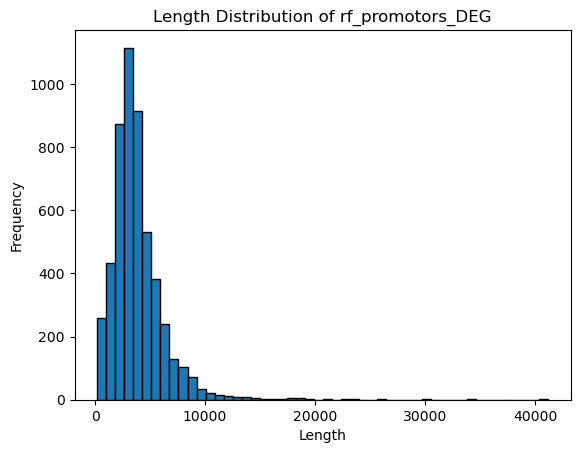

In [187]:
# Assuming 'length' is the column with the lengths
lengths = rf_promotors_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of rf_promotors_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### Gene Bodies

In [188]:
gene_bodies_df = pd.read_csv("/data/lvisser/Ensembl/gene_bodies_105.txt", sep = "\t", dtype={6: str})
gene_bodies_df.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcription start site (TSS),Gene name,Gene description
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,577,647,MT,577,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,648,1601,MT,648,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,1602,1670,MT,1602,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,1671,3229,MT,1671,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,3230,3304,MT,3230,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...


In [189]:
gene_bodies_105 = gene_bodies_df[["Gene start (bp)", "Gene end (bp)", "Chromosome/scaffold name", "Gene name"]].copy().dropna()
gene_bodies_105.columns = ["start", "end", "chrom", "gene_symbol"]
gene_bodies_105["chrom"] = "chr" + gene_bodies_105["chrom"]
valid_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']
gene_bodies_105 = gene_bodies_105[gene_bodies_105['chrom'].isin(valid_chromosomes)]
gene_bodies_105["segment_id"] = gene_bodies_105["chrom"] + ":" + gene_bodies_105["start"].astype(str) + "-" + gene_bodies_105["end"].astype(str)
gene_bodies_105["length"] = gene_bodies_105["end"] - gene_bodies_105["start"]
# Remove rows with duplicate 'gene_symbol' values
gene_bodies_105 = gene_bodies_105.drop_duplicates(subset='gene_symbol')
gene_bodies_105.drop_duplicates().to_csv("/data/lvisser/segmentations/gene_bodies_105.csv", index=False)

In [190]:
gene_bodies_105 = pd.read_csv("/data/lvisser/segmentations/gene_bodies_105.csv", dtype={2: str})
print(gene_bodies_105.shape)
gene_bodies_105.head()

(39620, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,577,647,chrMT,MT-TF,chrMT:577-647,70
1,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
2,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
3,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
4,3230,3304,chrMT,MT-TL1,chrMT:3230-3304,74


In [191]:
gene_bodies_DEG = gene_bodies_105[gene_bodies_105["gene_symbol"].isin(DEG_full["gene_symbol"])]
gene_bodies_DEG.to_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv", index=False)

In [192]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
print(gene_bodies_DEG.shape)
gene_bodies_DEG.head()

(6925, 6)


,start,end,chrom,gene_symbol,segment_id,length
0,648,1601,chrMT,MT-RNR1,chrMT:648-1601,953
1,1602,1670,chrMT,MT-TV,chrMT:1602-1670,68
2,1671,3229,chrMT,MT-RNR2,chrMT:1671-3229,1558
3,4402,4469,chrMT,MT-TM,chrMT:4402-4469,67
4,5587,5655,chrMT,MT-TA,chrMT:5587-5655,68


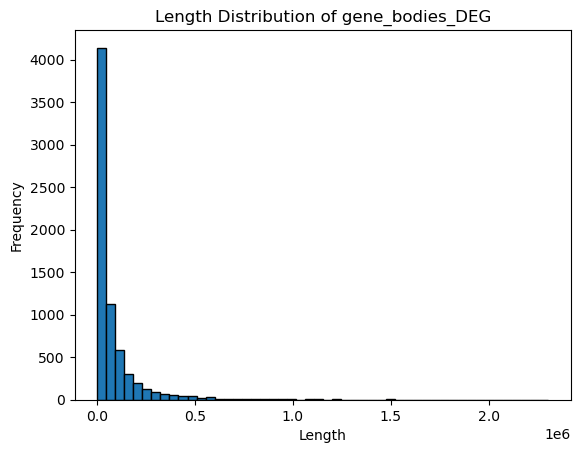

In [193]:
# Assuming 'length' is the column with the lengths
lengths = gene_bodies_DEG['length']

plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of gene_bodies_DEG')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### WGBS_tools

#### NB

In [194]:
def create_fm_wgbs(df, metadata):
    processed_df = df.select_dtypes(include=[float])
    processed_df['segment_id'] = df['segment_id']

    processed_df = processed_df.set_index('segment_id').dropna()
    processed_df = processed_df[processed_df.index.isin(df["segment_id"])].T

    # Reset the index and rename it to 'sample_id_adj'
    processed_df.reset_index(inplace=True)
    processed_df = processed_df.rename(columns={'index': 'sample_id_adj'})

    processed_df = processed_df.merge(metadata[["sample_id_adj", "source_directory", "Group", "tumor_type"]], on = "sample_id_adj", how = "left")
    
    return processed_df

In [195]:
def find_annot_overlap(df, annot):

    warnings.filterwarnings('ignore', category=FutureWarning)

    list1 = df.segment_id
    list2 = annot.segment_id

    # Convert the lists to PyRanges objects
    def convert_to_pyranges(list_of_segments):
        chromosomes = [seg.split(':')[0] for seg in list_of_segments]
        starts = [int(seg.split(':')[1].split('-')[0]) for seg in list_of_segments]
        ends = [int(seg.split(':')[1].split('-')[1]) for seg in list_of_segments]
        return pr.PyRanges(chromosomes=chromosomes, starts=starts, ends=ends)

    pr1 = convert_to_pyranges(list1)
    pr2 = convert_to_pyranges(list2)

    # Find overlapping segments
    overlapping_segments = pr1.join(pr2)

    # Convert to DataFrame
    overlapping_segments_df = overlapping_segments.df

    # Add segment_id column
    overlapping_segments_df['segment_id'] = overlapping_segments_df['Chromosome'].astype(str) + ':' + overlapping_segments_df['Start_b'].astype(str) + '-' + overlapping_segments_df['End_b'].astype(str)

    # Merge with gene_bodies_105 to add gene symbols
    overlapping_segments_df = overlapping_segments_df.merge(annot[["segment_id", "gene_symbol"]], on='segment_id', how='left').drop_duplicates()

    overlapping_segments_df['segment_id'] = overlapping_segments_df['Chromosome'].astype(str) + ':' + overlapping_segments_df['Start'].astype(str) + '-' + overlapping_segments_df['End'].astype(str)

    df_annot = df.merge(overlapping_segments_df[["segment_id", "gene_symbol"]], on = "segment_id", how = "left").drop_duplicates().dropna()

    # Remove duplicate segment_ids
    df_annot = df_annot.drop_duplicates(subset='segment_id')

    return df_annot

In [196]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/NB1_only/unfiltered"
wgbs_seg_nb1 = process_wgbs_seg_files(folder)
# wgbs_seg_nb1 = find_annot_overlap(wgbs_seg_nb1, gene_bodies_105)
wgbs_seg_nb1.to_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1.csv", index = False)

In [197]:
wgbs_seg_nb1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_nb1.csv")
print(wgbs_seg_nb1.shape)
wgbs_seg_nb1.head()

(1895562, 10)


,chrom,start,end,startCpG,endCpG,IMR14nov_R1,SHP12dec_R4,SHY2sept_R1,SKN14nov_R2,segment_id
0,chr22,10510235,10512049,27218094,27218104,0.88,0.04,0.04,0.06,chr22:10510235-10512049
1,chr22,10513853,10515736,27218105,27218120,0.92,0.02,0.08,0.07,chr22:10513853-10515736
2,chr22,10516017,10517750,27218120,27218125,1.00,0.15,0.00,0.00,chr22:10516017-10517750
3,chr22,10518304,10520219,27218125,27218137,1.00,0.00,0.00,0.09,chr22:10518304-10520219
4,chr22,10520752,10522650,27218139,27218150,NaN,0.11,0.00,0.06,chr22:10520752-10522650


In [198]:
meth_seg_wgbs_nb1_fm = create_fm_wgbs(wgbs_seg_nb1, metadata)
meth_seg_wgbs_nb1_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_nb1_fm.csv", index = False)
print(meth_seg_wgbs_nb1_fm.shape)
meth_seg_wgbs_nb1_fm.head()

(4, 1546160)


,sample_id_adj,chr22:10510235-10512049,chr22:10513853-10515736,chr22:10516017-10517750,chr22:10518304-10520219,chr22:10522965-10524772,chr22:10525487-10525747,chr22:10525749-10525908,chr22:10525917-10525931,chr22:10525943-10526051,...,chr9:138243659-138245623,chr9:138256043-138257768,chr9:138258705-138260224,chr9:138301800-138302861,chr9:138303904-138304191,chr9:138314410-138315821,chr9:138316464-138318349,source_directory,Group,tumor_type
0,IMR14nov_R1,0.88,0.92,1.00,1.00,1.00,1.00,0.97,1.00,0.89,...,0.95,0.67,0.84,1.00,1.00,0.85,0.14,data_OHMX20230016R_20231114,S,NB
1,SHP12dec_R4,0.04,0.02,0.15,0.00,0.04,0.84,0.96,0.89,0.91,...,0.00,0.00,0.00,0.25,0.86,0.09,0.00,data_OHMX20230016R_20231114,S,NB
2,SHY2sept_R1,0.04,0.08,0.00,0.00,0.00,0.81,0.56,0.34,0.62,...,0.88,1.00,1.00,0.80,0.93,1.00,1.00,data_OHMX20230016R_20231114,R,NB
3,SKN14nov_R2,0.06,0.07,0.00,0.09,0.02,0.71,0.59,0.17,0.74,...,0.37,0.00,0.16,0.23,0.40,0.33,0.11,data_OHMX20230016R_20231114,R,NB


In [199]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/NB1_only/unfiltered'  # replace with your folder
wgbs_dmr_nb1 = process_wgbs_dmr_files(folder)
wgbs_dmr_nb1.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb1.csv", index = False)

In [200]:
wgbs_dmr_nb1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_nb1.csv")
print(wgbs_dmr_nb1.shape)
wgbs_dmr_nb1.head()

(37200, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,gene_symbol,length
0,chr8,339324,339424,12448810,12448816,R,chr8:339324-339424,6CpGs,100bp,0.1650,0.746,0.581,0.457,0.404,0.0442,U,none,100
1,chr8,636727,636822,12453158,12453162,R,chr8:636727-636822,4CpGs,95bp,0.3810,0.882,0.501,0.471,0.446,0.0091,U,none,95
2,chr8,1373259,1373562,12470337,12470371,R,chr8:1373259-1373562,34CpGs,303bp,0.0185,0.813,0.794,0.707,0.693,0.0111,U,none,303
3,chr8,1956798,1957098,12483994,12484007,R,chr8:1956798-1957098,13CpGs,300bp,0.1170,0.909,0.792,0.684,0.658,0.0157,U,none,300
4,chr8,1958036,1958341,12484025,12484039,R,chr8:1958036-1958341,14CpGs,305bp,0.0329,0.607,0.574,0.503,0.499,0.0160,U,none,305


#### MM

In [201]:
# Call the function
folder = "/data/lvisser/wgbs_tools/outputs/segmentations/MM1_only/unfiltered"
wgbs_seg_mm1 = process_wgbs_seg_files(folder)
# wgbs_seg_mm1 = find_annot_overlap(wgbs_seg_mm1, gene_bodies_105)
wgbs_seg_mm1.to_csv("/data/lvisser/feature_matrices/wgbs_seg_mm1.csv", index = False)

In [202]:
wgbs_seg_mm1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_seg_mm1.csv")
print(wgbs_seg_mm1.shape)
wgbs_seg_mm1.head()

(2436165, 10)


,chrom,start,end,startCpG,endCpG,JJN3_2_1,MM1R_4_3,OPM_4_3,RPMI8226_3_3,segment_id
0,chr22,10510235,10511697,27218094,27218102,0.22,0.8,NaN,1.0,chr22:10510235-10511697
1,chr22,10512833,10514603,27218104,27218110,0.30,1.0,NaN,0.9,chr22:10512833-10514603
2,chr22,10514792,10514994,27218110,27218115,NaN,NaN,NaN,NaN,chr22:10514792-10514994
3,chr22,10515170,10517014,27218115,27218124,0.25,NaN,NaN,1.0,chr22:10515170-10517014
4,chr22,10517749,10518350,27218124,27218127,NaN,NaN,NaN,NaN,chr22:10517749-10518350


In [203]:
meth_seg_wgbs_mm1_fm = create_fm_wgbs(wgbs_seg_mm1, metadata)
meth_seg_wgbs_mm1_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_wgbs_mm1_fm.csv", index = False)
print(meth_seg_wgbs_mm1_fm.shape)
meth_seg_wgbs_mm1_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


In [204]:
# Call the function
folder = '/data/lvisser/wgbs_tools/outputs/dmr/MM1_only/unfiltered'  # replace with your folder
wgbs_dmr_mm1 = process_wgbs_dmr_files(folder)
wgbs_dmr_mm1.to_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm1.csv", index = False)

In [205]:
wgbs_dmr_mm1 = pd.read_csv("/data/lvisser/feature_matrices/wgbs_dmr_mm1.csv")
print(wgbs_dmr_mm1.shape)
wgbs_dmr_mm1.head()

(51158, 18)


,chrom,start,end,startCpG,endCpG,target,segment_id,lenCpG,bp,tg_mean,bg_mean,delta_means,delta_quants,delta_maxmin,ttest,direction,gene_symbol,length
0,chr8,735644,735839,12456016,12456020,R,chr8:735644-735839,4CpGs,195bp,0.0417,0.366,0.324,0.295,0.274,0.01680,U,none,195
1,chr8,744182,744209,12456453,12456456,R,chr8:744182-744209,3CpGs,27bp,0.3100,0.798,0.488,0.457,0.444,0.00406,U,none,27
2,chr8,1733185,1733229,12478474,12478479,R,chr8:1733185-1733229,5CpGs,44bp,0.2150,0.909,0.694,0.600,0.587,0.01720,U,none,44
3,chr8,2033622,2033665,12486006,12486011,R,chr8:2033622-2033665,5CpGs,43bp,0.6180,0.977,0.359,0.328,0.318,0.00651,U,none,43
4,chr8,2056508,2058050,12486478,12486516,R,chr8:2056508-2058050,38CpGs,1542bp,0.3610,0.937,0.576,0.513,0.462,0.02970,U,none,1542


## Feature Extraction/Reduction

### Annotation-Based

#### Promotor Regions

In [206]:
cpg_promotors_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_promotors_df.shape)
cpg_promotors_df.head()

(105555914, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17024844,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.038086
1,chr15,17024908,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.989258
2,chr15,17024909,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.018555
3,chr15,17024994,data_OHMX20230016R_20231114,IMR14nov_R1,10,0.306250
4,chr15,17024995,data_OHMX20230016R_20231114,IMR14nov_R1,4,0.244141


In [207]:
rf_promotors_DEG = pd.read_csv("/data/lvisser/segmentations/rf_promotors_DEG.csv")
meth_seg_promotors = cpg2segment_aggregation_trees(cpg_promotors_df, rf_promotors_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_promotors.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 184/184 [35:32<00:00, 11.59s/it] 


In [208]:
meth_seg_promotors = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors.csv")
meth_seg_promotors['positions'] = meth_seg_promotors['positions'].apply(ast.literal_eval)
meth_seg_promotors['mod_qual_positions'] = meth_seg_promotors['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_promotors.shape)
meth_seg_promotors.head()

(41456, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,SHP12dec_R4,chr10:100007200-100011200,data_OHMX20230016R_20231114,10.963867,"[100008393, 100008400, 100008481, 100009965, 1...","[0.13964844, 0.14355469, 0.0068359375, 0.26855...",52,0.210844,DNMBP,4000,chr10
1,SHY2sept_R1,chr10:100007200-100011200,data_OHMX20230016R_20231114,20.630925,"[100008392, 100008393, 100008399, 100008400, 1...","[0.9970703, 0.70214844, 0.99902344, 0.9951172,...",66,0.312590,DNMBP,4000,chr10
2,SKN14nov_R2,chr10:100007200-100011200,data_OHMX20230016R_20231114,18.848796,"[100008392, 100008393, 100008399, 100008400, 1...","[0.914550785, 0.99804687, 0.997558595, 0.99609...",46,0.409756,DNMBP,4000,chr10
3,MM1R_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,18.136719,"[100008400, 100009775, 100009964, 100009965, 1...","[0.9951172, 0.5390625, 0.07714844, 0.35742187,...",69,0.262851,DNMBP,4000,chr10
4,OPM_4_3,chr10:100007200-100011200,data_OHMX20230016R_MM_2,17.936523,"[100008393, 100008399, 100008400, 100008481, 1...","[0.9638672, 0.99804687, 0.85253906, 0.99902344...",45,0.398589,DNMBP,4000,chr10


In [209]:
meth_seg_promotors_fm = create_fm(meth_seg_promotors, metadata)
meth_seg_promotors_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv", index = False)

In [210]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4745)


,Group,sample_id_adj,source_directory,chr10:100007200-100011200,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,...,chrX:81119601-81122600,chrX:85002601-85005201,chrX:85375201-85380000,chrX:8729800-8732801,chrX:91434001-91436601,chrX:9462800-9468201,chrX:9764801-9766201,chrX:9785000-9788401,chrX:9912200-9915000,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.290123,0.286979,0.669037,0.484533,0.217334,0.221267,0.221540,...,0.119683,0.131966,0.0,0.290820,0.761475,0.130469,0.942758,0.840195,0.902930,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.210844,0.279630,0.837943,0.555257,0.217633,0.805809,0.664258,...,0.038379,0.397461,0.0,0.539388,0.392643,0.422164,0.850849,0.714821,0.320457,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.312590,0.297658,0.785635,0.537883,0.248456,0.271168,0.292039,...,0.034686,0.200439,0.0,0.239757,0.357178,0.140259,0.424845,0.684925,0.363281,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.409756,0.194222,0.645020,0.392968,0.199697,0.241347,0.252734,...,0.038737,0.087416,0.0,0.206008,0.260742,0.141866,0.819221,0.630834,0.048828,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.316730,0.212823,0.528454,0.515598,0.216315,0.219263,0.316882,...,0.035156,0.145278,0.0,0.412621,0.387695,0.314923,0.684226,0.313171,0.388672,MM


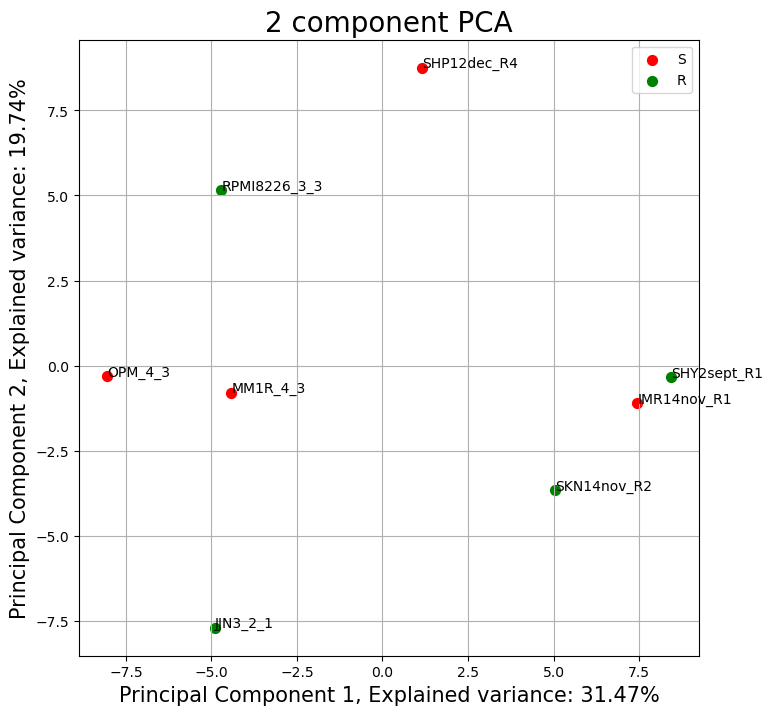

In [211]:
pca_plot(meth_seg_promotors_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Gene Bodies

In [212]:
cpg_genebds_df = pd.read_csv("/data/lvisser/feature_matrices/concatenated_tables/all_samples/cpg_cat_all_unicvg.csv")
print(cpg_genebds_df.shape)
cpg_genebds_df.head()

(105555914, 6)


,chrom,ref_position,source_directory,sample_id_adj,cpg_coverage,mod_qual
0,chr15,17024844,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.038086
1,chr15,17024908,data_OHMX20230016R_20231114,IMR14nov_R1,2,0.989258
2,chr15,17024909,data_OHMX20230016R_20231114,IMR14nov_R1,1,0.018555
3,chr15,17024994,data_OHMX20230016R_20231114,IMR14nov_R1,10,0.306250
4,chr15,17024995,data_OHMX20230016R_20231114,IMR14nov_R1,4,0.244141


In [213]:
gene_bodies_DEG = pd.read_csv("/data/lvisser/segmentations/gene_bodies_DEG.csv")
meth_seg_genebds = cpg2segment_aggregation_trees(cpg_genebds_df, gene_bodies_DEG[["chrom", "start", "end", "segment_id", "gene_symbol", "length"]].copy())
meth_seg_genebds.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv", index = False)

initializing meth_seg...


Aggregating: 100%|██████████| 200/200 [1:27:36<00:00, 26.28s/it]


In [214]:
meth_seg_genebds = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds.csv")
meth_seg_genebds['positions'] = meth_seg_genebds['positions'].apply(ast.literal_eval)
meth_seg_genebds['mod_qual_positions'] = meth_seg_genebds['mod_qual_positions'].apply(ast.literal_eval)
print(meth_seg_genebds.shape)
meth_seg_genebds.head()

(55400, 11)


,sample_id_adj,segment_id,source_directory,total_methylation,positions,mod_qual_positions,num_cpgs,avg_methylation,gene_symbol,length,chrom
0,RPMI8226_3_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,243.810195,"[100152160, 100153786, 100153977, 100154106, 1...","[0.99121094, 0.99316406, 0.9892578, 0.99804687...",347,0.702623,ERLIN1,35939,chr10
1,MM1R_4_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,227.587316,"[100150199, 100152159, 100152255, 100152337, 1...","[0.50097656, 0.9873047, 0.98535156, 0.9560547,...",347,0.655871,ERLIN1,35939,chr10
2,JJN3_2_1,chr10:100150094-100186033,data_OHMX20230016R_MM_2,226.628349,"[100150199, 100152159, 100152160, 100152255, 1...","[0.99414063, 0.92382813, 0.9970703, 0.99902344...",348,0.651231,ERLIN1,35939,chr10
3,OPM_4_3,chr10:100150094-100186033,data_OHMX20230016R_MM_2,206.540227,"[100150199, 100152159, 100152160, 100152255, 1...","[0.765625, 0.036132813, 0.9970703, 0.9970703, ...",326,0.633559,ERLIN1,35939,chr10
4,SHY2sept_R1,chr10:100150094-100186033,data_OHMX20230016R_20231114,259.441940,"[100150199, 100152159, 100152160, 100152255, 1...","[0.94042968, 0.99804687, 0.9970703066666666, 0...",371,0.699304,ERLIN1,35939,chr10


In [215]:
meth_seg_genebds_fm = create_fm(meth_seg_genebds, metadata)
meth_seg_genebds_fm.to_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv", index = False)

In [216]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

(8, 6672)


,Group,sample_id_adj,source_directory,chr10:100150094-100186033,chr10:100232298-100267680,chr10:100273280-100286680,chr10:100347233-100364826,chr10:100463009-100483744,chr10:100735396-100829944,chr10:100969518-100985871,...,chrX:8528874-8732137,chrX:87517409-87670050,chrX:89921908-89922883,chrX:91434595-91438584,chrX:91779261-92623230,chrX:93674013-93712274,chrX:9463320-9741037,chrX:9725346-9786297,chrX:9786429-9949443,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.654308,0.919633,0.778300,0.679719,0.441944,0.473404,0.895362,...,0.711954,0.504883,0.988281,0.761475,0.931853,0.970672,0.900731,0.939126,0.941955,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.680587,0.928848,0.873169,0.652430,0.426032,0.439927,0.900292,...,0.311011,0.042969,0.045898,0.392643,0.211329,0.477329,0.592505,0.730360,0.787372,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.699304,0.909993,0.744086,0.642068,0.605702,0.440883,0.915816,...,0.511585,0.050781,0.030273,0.357178,0.224058,0.322418,0.677907,0.647684,0.589921,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.690636,0.881976,0.745776,0.606008,0.367547,0.391530,0.833200,...,0.294577,0.041992,0.033203,0.260742,0.389987,0.735502,0.907118,0.668937,0.385445,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.651231,0.840759,0.765911,0.595766,0.261928,0.252834,0.675543,...,0.268507,0.996094,0.032227,0.387695,0.398054,0.464374,0.781714,0.493714,0.545954,MM


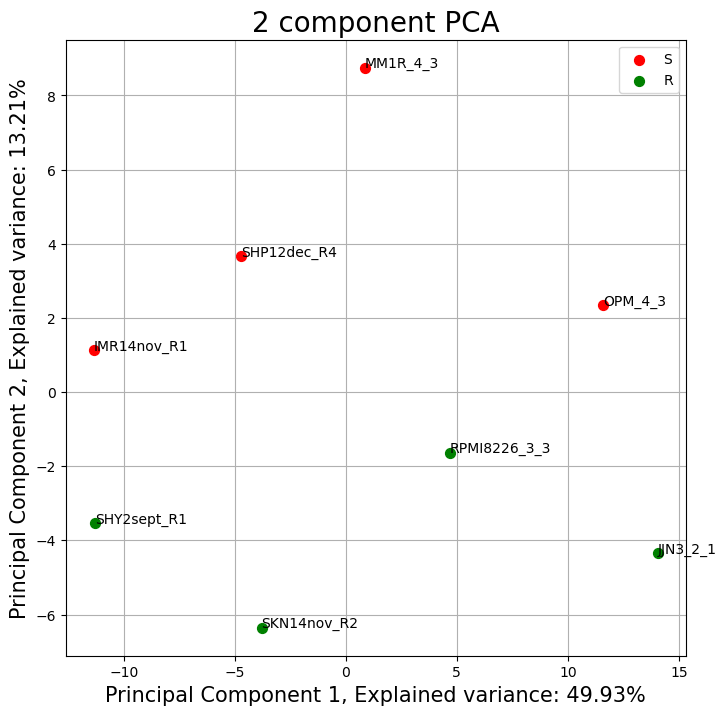

In [217]:
pca_plot(meth_seg_genebds_fm, n_components=2, group_column="Group", label_column = "sample_id_adj")

#### Correlation Transcription-Methylation

In [218]:
correlations_promotors_df = tm_pcc(meth_seg_promotors, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_promotors.csv")
print(correlations_promotors_df.shape)
correlations_promotors_df.head()

Average methylation - log2counts pearson correlation: -0.10262929365735148
p-value: 1.295125592601539e-61
Total methylation - log2counts pearson correlation: 0.07552819292203214
p-value: 4.2622573240109e-34
(4293, 3)


,gene_symbol,correlation,p_value
1564,SERPINB7,0.999741,0.000005
1102,ARPIN,0.998711,0.000056
4164,MPDZ,0.998566,0.000065
3167,ANXA5,-0.998158,0.000095
390,TRIM22,0.997998,0.000108


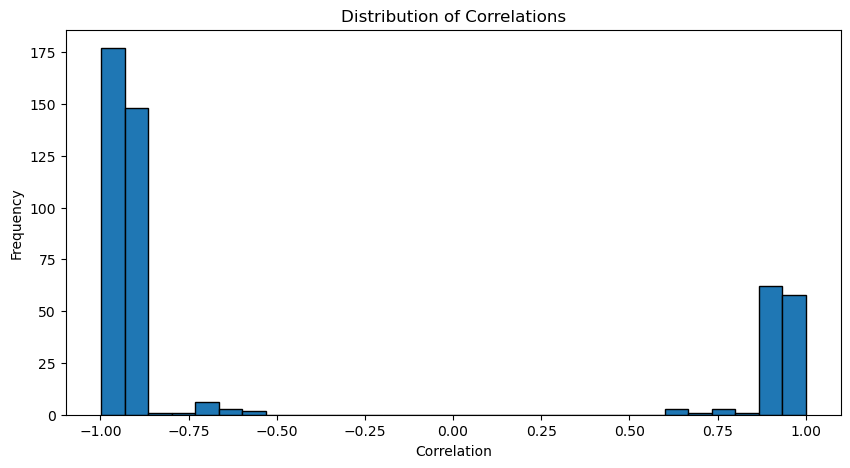

In [219]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_promotors_df[correlations_promotors_df["p_value"] < 0.05])

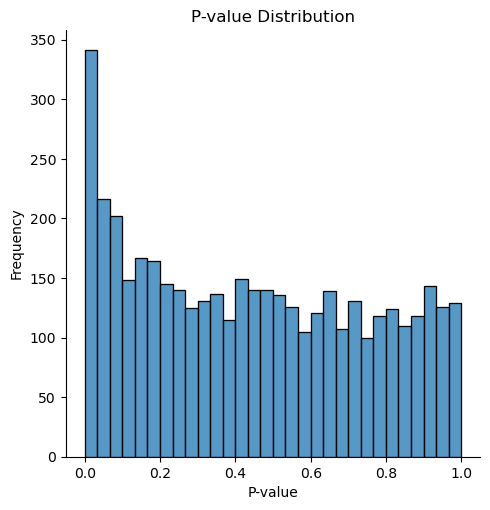

In [220]:
plot_pvalue_distribution(correlations_promotors_df["p_value"])

In [221]:
correlations_genebds_df = tm_pcc(meth_seg_genebds, metadata, DEG_full, "/data/lvisser/tm_pcc/tm_pcc_genebds.csv")
print(correlations_genebds_df.shape)
correlations_genebds_df.head()

Average methylation - log2counts pearson correlation: 0.3741393229992128
p-value: 0.0
Total methylation - log2counts pearson correlation: 0.26172801653965033
p-value: 0.0
(6619, 3)


,gene_symbol,correlation,p_value
589,HBD,1.000000,0.000000e+00
1466,CXADRP2,0.999923,8.059755e-07
6481,IFNE,0.999846,2.294561e-06
2949,LINC01772,0.999227,2.579180e-05
112,BEND7,0.999151,2.968308e-05


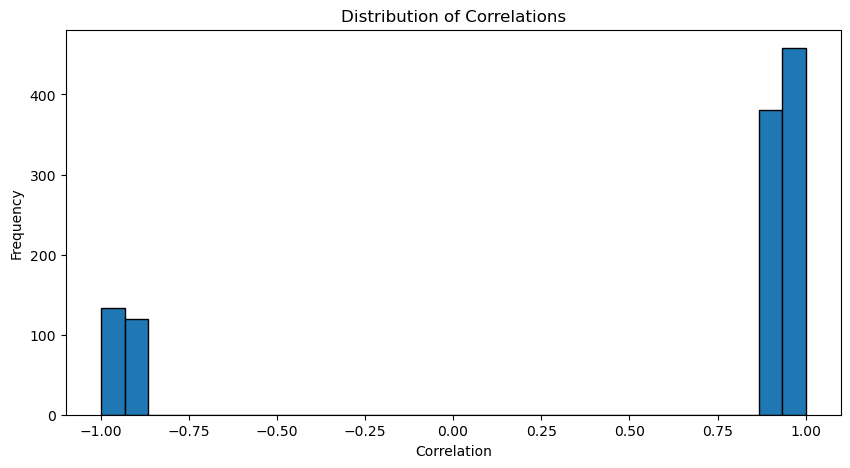

In [222]:
# Call the function with your correlations DataFrame
plot_correlation_distribution(correlations_genebds_df[correlations_genebds_df["p_value"] < 0.05])

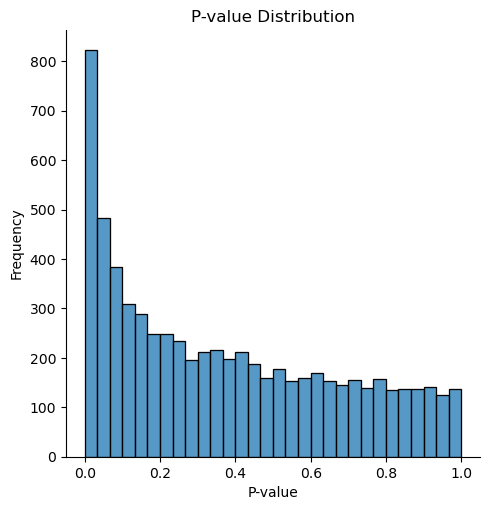

In [223]:
plot_pvalue_distribution(correlations_genebds_df["p_value"])

## Model Training

### Promotor Regions

In [224]:
meth_seg_promotors_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_promotors_fm.csv")
print(meth_seg_promotors_fm.shape)
meth_seg_promotors_fm.head()

(8, 4745)


,Group,sample_id_adj,source_directory,chr10:100007200-100011200,chr10:100183600-100187801,chr10:100266000-100268800,chr10:100284600-100287601,chr10:100345600-100351401,chr10:100745000-100746201,chr10:100968800-100972001,...,chrX:81119601-81122600,chrX:85002601-85005201,chrX:85375201-85380000,chrX:8729800-8732801,chrX:91434001-91436601,chrX:9462800-9468201,chrX:9764801-9766201,chrX:9785000-9788401,chrX:9912200-9915000,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.290123,0.286979,0.669037,0.484533,0.217334,0.221267,0.221540,...,0.119683,0.131966,0.0,0.290820,0.761475,0.130469,0.942758,0.840195,0.902930,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.210844,0.279630,0.837943,0.555257,0.217633,0.805809,0.664258,...,0.038379,0.397461,0.0,0.539388,0.392643,0.422164,0.850849,0.714821,0.320457,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.312590,0.297658,0.785635,0.537883,0.248456,0.271168,0.292039,...,0.034686,0.200439,0.0,0.239757,0.357178,0.140259,0.424845,0.684925,0.363281,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.409756,0.194222,0.645020,0.392968,0.199697,0.241347,0.252734,...,0.038737,0.087416,0.0,0.206008,0.260742,0.141866,0.819221,0.630834,0.048828,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.316730,0.212823,0.528454,0.515598,0.216315,0.219263,0.316882,...,0.035156,0.145278,0.0,0.412621,0.387695,0.314923,0.684226,0.313171,0.388672,MM


In [231]:
meth_seg_promotors_fm_NB = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "NB"]
meth_seg_promotors_fm_MM = meth_seg_promotors_fm[meth_seg_promotors_fm["tumor_type"] == "MM"]

#### NB

Regularization has removed 4343 features of the original 4741.
Sample: 0
Cell line: SHY2sept_R1
True label: R
Predicted label: S
Probabilities:
['R']: 0.471930250775337
['S']: 0.528069749224663



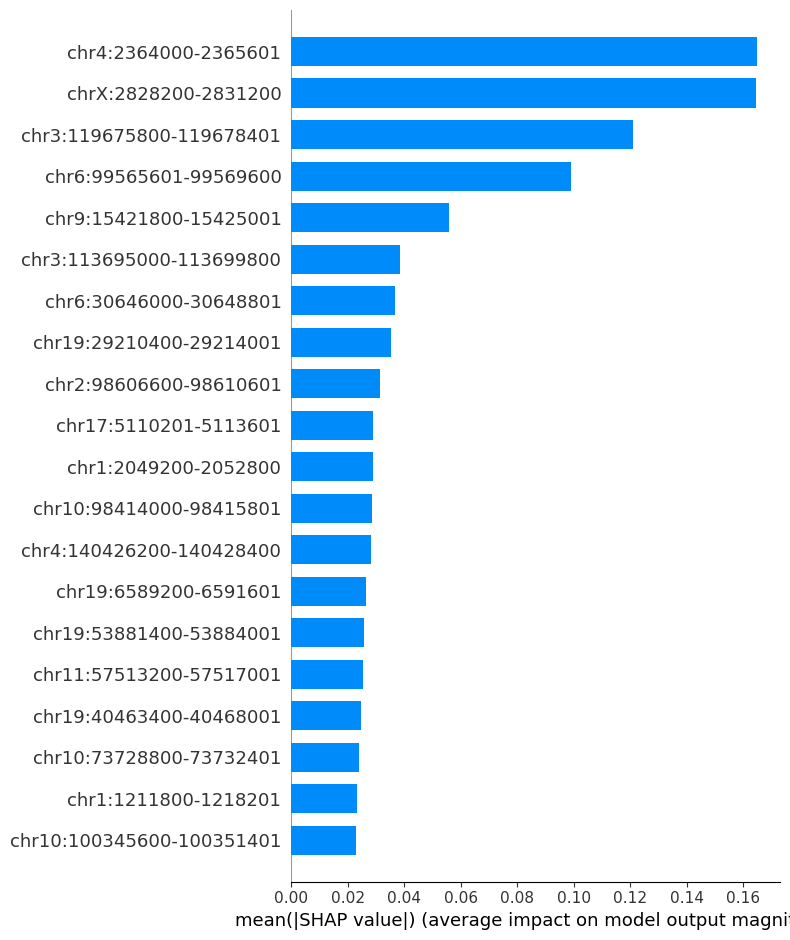

PCA after filtering:


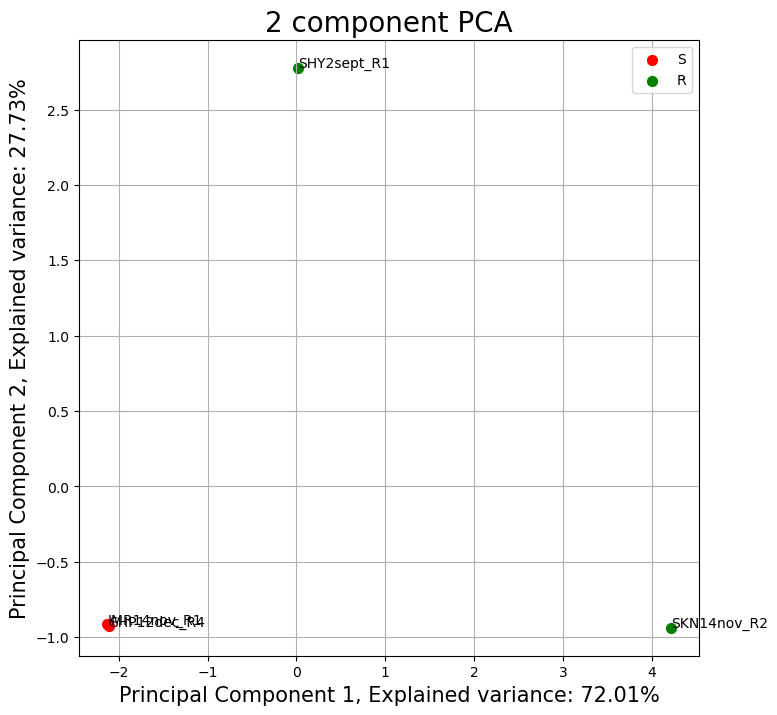

In [234]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_promotors_fm_NB, test_size = 0.25, reg = True)

In [235]:
train_and_predict_loo(meth_seg_promotors_fm_NB, reg = True, dmr = "ttest")

Average accuracy: 0.75


#### MM

Regularization has removed 4314 features of the original 4741.
Sample: 0
Cell line: RPMI8226_3_3
True label: R
Predicted label: S
Probabilities:
['R']: 0.24708449874293192
['S']: 0.7529155012570681



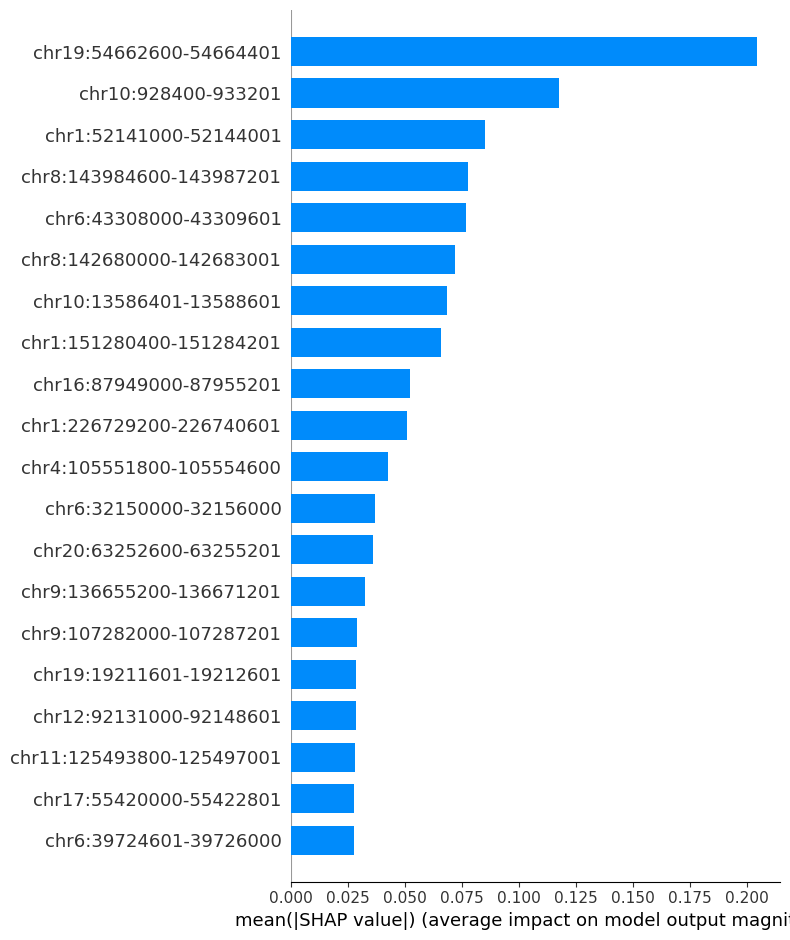

PCA after filtering:


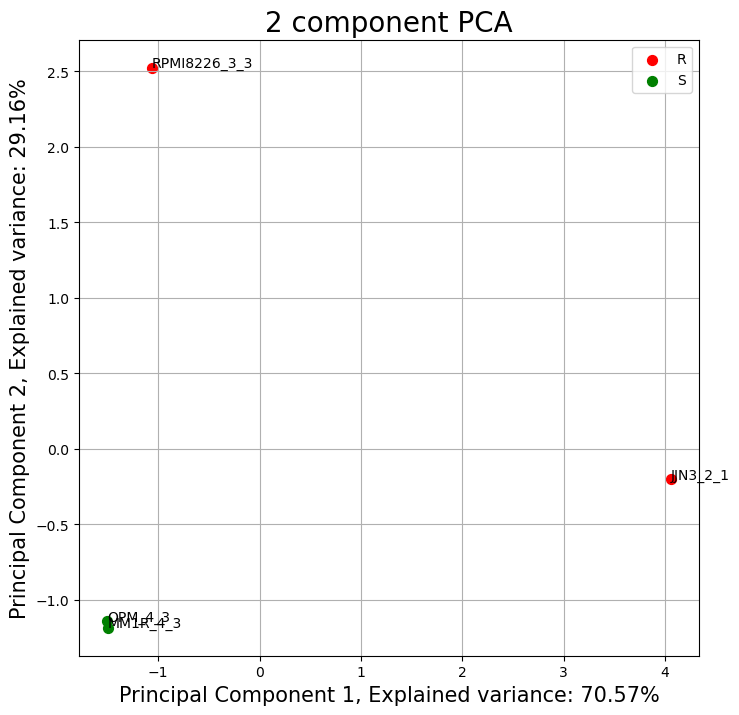

In [236]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_promotors_fm_MM, test_size = 0.25, reg = True)

In [237]:
train_and_predict_loo(meth_seg_promotors_fm_MM, reg = True)

Average accuracy: 0.25


### Gene Bodies

In [238]:
meth_seg_genebds_fm = pd.read_csv("/data/lvisser/feature_matrices/meth_seg_genebds_fm.csv")
print(meth_seg_genebds_fm.shape)
meth_seg_genebds_fm.head()

(8, 6672)


,Group,sample_id_adj,source_directory,chr10:100150094-100186033,chr10:100232298-100267680,chr10:100273280-100286680,chr10:100347233-100364826,chr10:100463009-100483744,chr10:100735396-100829944,chr10:100969518-100985871,...,chrX:8528874-8732137,chrX:87517409-87670050,chrX:89921908-89922883,chrX:91434595-91438584,chrX:91779261-92623230,chrX:93674013-93712274,chrX:9463320-9741037,chrX:9725346-9786297,chrX:9786429-9949443,tumor_type
0,S,IMR14nov_R1,data_OHMX20230016R_20231114,0.654308,0.919633,0.778300,0.679719,0.441944,0.473404,0.895362,...,0.711954,0.504883,0.988281,0.761475,0.931853,0.970672,0.900731,0.939126,0.941955,NB
1,S,SHP12dec_R4,data_OHMX20230016R_20231114,0.680587,0.928848,0.873169,0.652430,0.426032,0.439927,0.900292,...,0.311011,0.042969,0.045898,0.392643,0.211329,0.477329,0.592505,0.730360,0.787372,NB
2,R,SHY2sept_R1,data_OHMX20230016R_20231114,0.699304,0.909993,0.744086,0.642068,0.605702,0.440883,0.915816,...,0.511585,0.050781,0.030273,0.357178,0.224058,0.322418,0.677907,0.647684,0.589921,NB
3,R,SKN14nov_R2,data_OHMX20230016R_20231114,0.690636,0.881976,0.745776,0.606008,0.367547,0.391530,0.833200,...,0.294577,0.041992,0.033203,0.260742,0.389987,0.735502,0.907118,0.668937,0.385445,NB
4,R,JJN3_2_1,data_OHMX20230016R_MM_2,0.651231,0.840759,0.765911,0.595766,0.261928,0.252834,0.675543,...,0.268507,0.996094,0.032227,0.387695,0.398054,0.464374,0.781714,0.493714,0.545954,MM


In [239]:
meth_seg_genebds_fm_NB = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "NB"]
meth_seg_genebds_fm_MM = meth_seg_genebds_fm[meth_seg_genebds_fm["tumor_type"] == "MM"]

#### NB

Regularization has removed 5922 features of the original 6668.
Sample: 0
Cell line: SHY2sept_R1
True label: R
Predicted label: S
Probabilities:
['R']: 0.30097211075599584
['S']: 0.6990278892440042



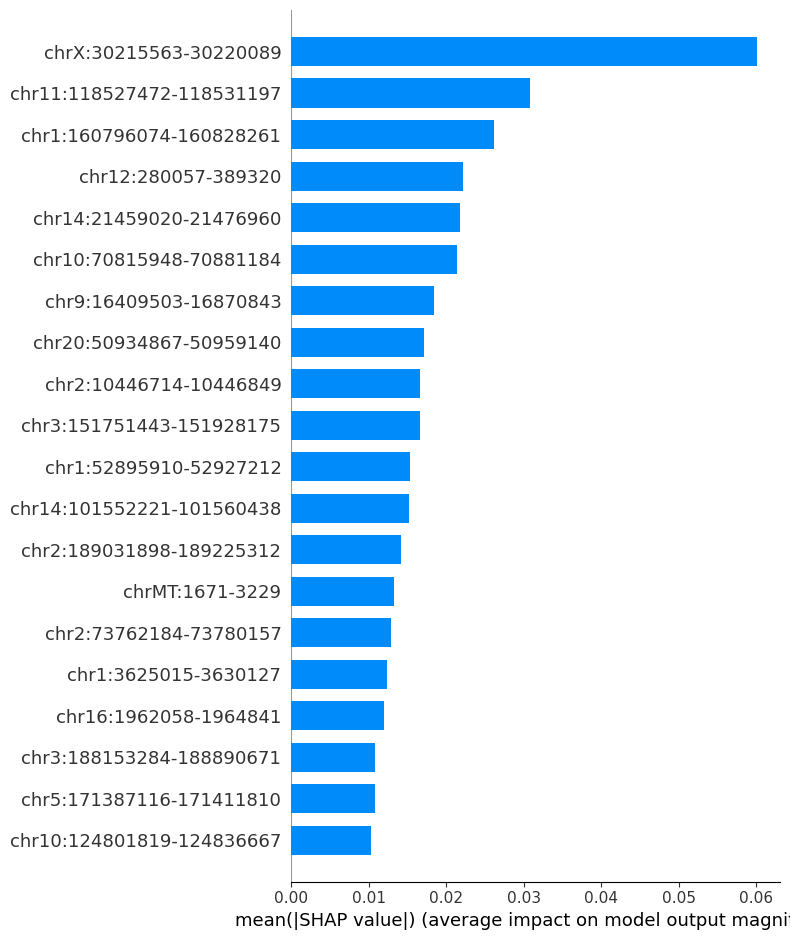

PCA after filtering:


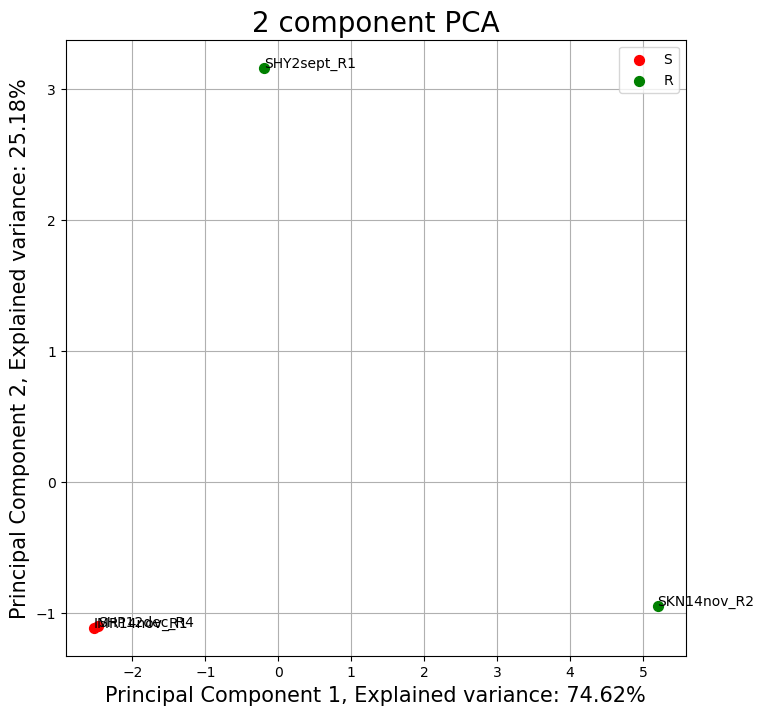

In [240]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_genebds_fm_NB, test_size = 0.25, reg = True)

In [241]:
train_and_predict_loo(meth_seg_genebds_fm_NB, reg = True)

Average accuracy: 0.5


#### MM

Regularization has removed 6210 features of the original 6668.
Sample: 0
Cell line: JJN3_2_1
True label: R
Predicted label: S
Probabilities:
['R']: 0.29879867436986707
['S']: 0.7012013256301329



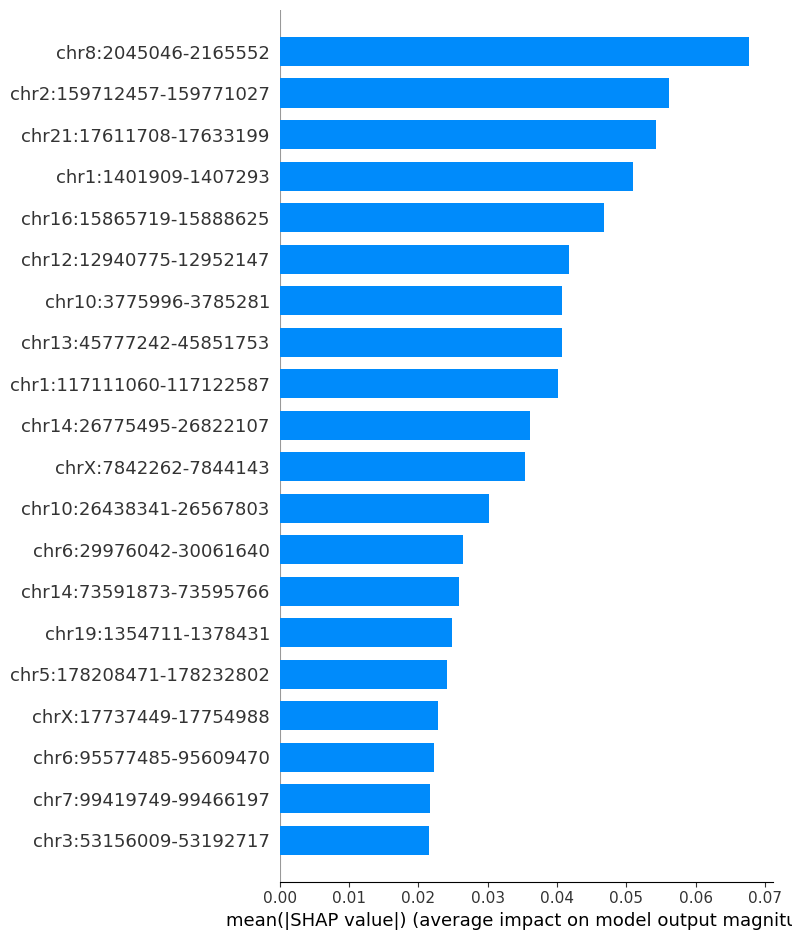

PCA after filtering:


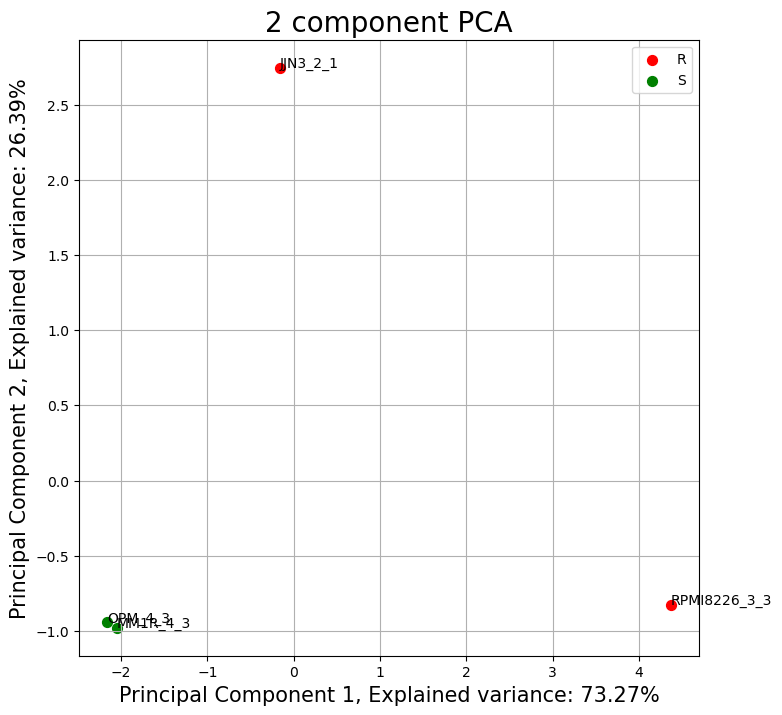

In [242]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_genebds_fm_MM, test_size = 0.25, reg = True)

In [243]:
train_and_predict_loo(meth_seg_genebds_fm_MM, reg = True)

Average accuracy: 0.25


### WGBS_tools

#### NB

In [89]:
print(meth_seg_wgbs_nb1_fm.shape)
meth_seg_wgbs_nb1_fm.head()

(4, 915953)


,sample_id_adj,chr22:10734826-10736556,chr22:10940062-10941931,chr22:10942442-10944124,chr22:10944167-10944925,chr22:10945022-10946947,chr22:10948560-10950545,chr22:10950607-10952403,chr22:10952514-10953931,chr22:10954165-10955691,...,chr9:138234662-138235402,chr9:138235444-138235580,chr9:138235594-138235929,chr9:138235956-138236478,chr9:138236607-138238521,chr9:138243659-138245623,chr9:138258705-138260224,source_directory,Group,tumor_type
0,IMR14nov_R1,0.96,1.00,0.96,1.00,1.00,1.00,1.00,0.91,0.96,...,0.62,0.94,0.88,0.92,0.91,0.95,0.84,data_OHMX20230016R_20231114,S,NB
1,SHP12dec_R4,0.02,0.30,0.47,0.56,0.49,0.14,0.26,0.21,0.51,...,0.16,0.44,0.31,0.79,0.13,0.00,0.00,data_OHMX20230016R_20231114,S,NB
2,SHY2sept_R1,0.02,0.07,0.12,0.73,0.00,0.02,0.13,0.00,0.00,...,0.38,0.94,0.37,0.83,0.88,0.88,1.00,data_OHMX20230016R_20231114,R,NB
3,SKN14nov_R2,0.04,0.10,0.04,0.13,0.06,0.10,0.39,0.33,0.17,...,0.00,0.58,0.05,0.67,0.27,0.37,0.16,data_OHMX20230016R_20231114,R,NB


DMR has removed 1459973 features of the original 1546156.
Regularization has removed 23259 features of the original 86183.
Sample: 0
Cell line: SKN14nov_R2
True label: R
Predicted label: R
Probabilities:
['R']: 0.8001179771309563
['S']: 0.19988202286904372



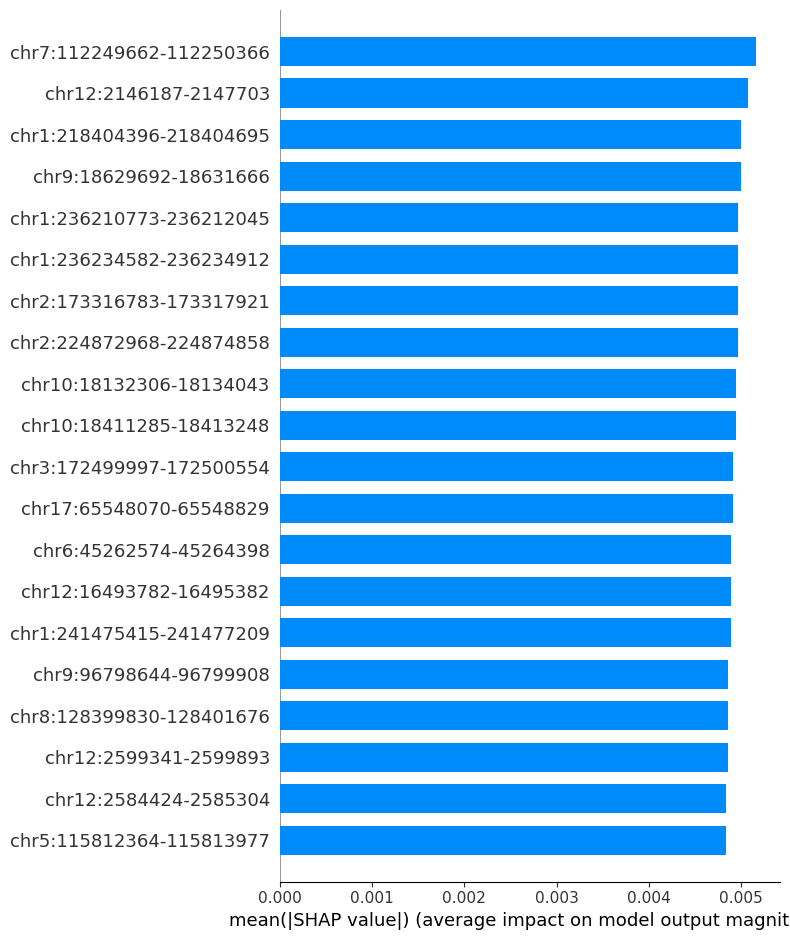

PCA after filtering:


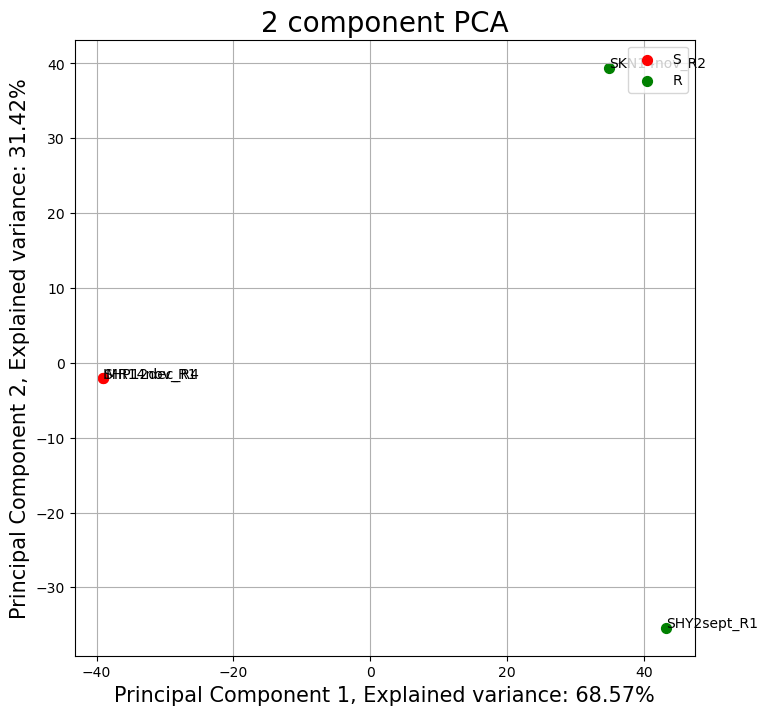

In [158]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_wgbs_nb1_fm, test_size = 0.25, reg = True, dmr = "ttest")

In [128]:
train_and_predict_loo(meth_seg_wgbs_nb1_fm, reg = True, dmr = "ttest")

Average accuracy: 1.0
Average F1 score: 0.5


#### MM

In [130]:
print(meth_seg_wgbs_mm1_fm.shape)
meth_seg_wgbs_mm1_fm.head()

(4, 1640061)


,sample_id_adj,chr22:10519035-10520844,chr22:10523473-10525269,chr22:10525487-10525946,chr22:10525988-10526067,chr22:10526102-10526125,chr22:10526140-10526194,chr22:10526196-10526215,chr22:10526238-10526899,chr22:10526908-10528747,...,chr9:138230113-138231335,chr9:138231458-138231709,chr9:138231832-138232715,chr9:138232777-138234470,chr9:138234559-138235402,chr9:138235579-138237577,chr9:138258705-138259649,source_directory,Group,tumor_type
0,JJN3_2_1,0.04,0.25,0.71,0.48,0.24,0.68,0.27,0.66,0.79,...,0.00,0.16,0.01,0.10,0.08,0.11,0.27,data_OHMX20230016R_MM_2,R,MM
1,MM1R_4_3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,...,0.00,0.40,0.59,0.45,0.08,0.53,0.38,data_OHMX20230016R_MM_2,S,MM
2,OPM_4_3,0.00,0.30,0.58,1.00,0.25,0.78,0.12,0.46,0.44,...,0.02,0.50,0.44,0.32,0.27,0.14,0.00,data_OHMX20230016R_MM_2,S,MM
3,RPMI8226_3_3,1.00,1.00,1.00,0.97,1.00,0.90,1.00,0.98,0.99,...,0.03,0.29,0.19,0.07,0.09,0.20,0.00,data_OHMX20230016R_MM_2,R,MM


DMR has removed 1557280 features of the original 1640057.
Regularization has removed 26658 features of the original 82777.
Sample: 0
Cell line: RPMI8226_3_3
True label: R
Predicted label: R
Probabilities:
['R']: 0.9455754921086443
['S']: 0.05442450789135569



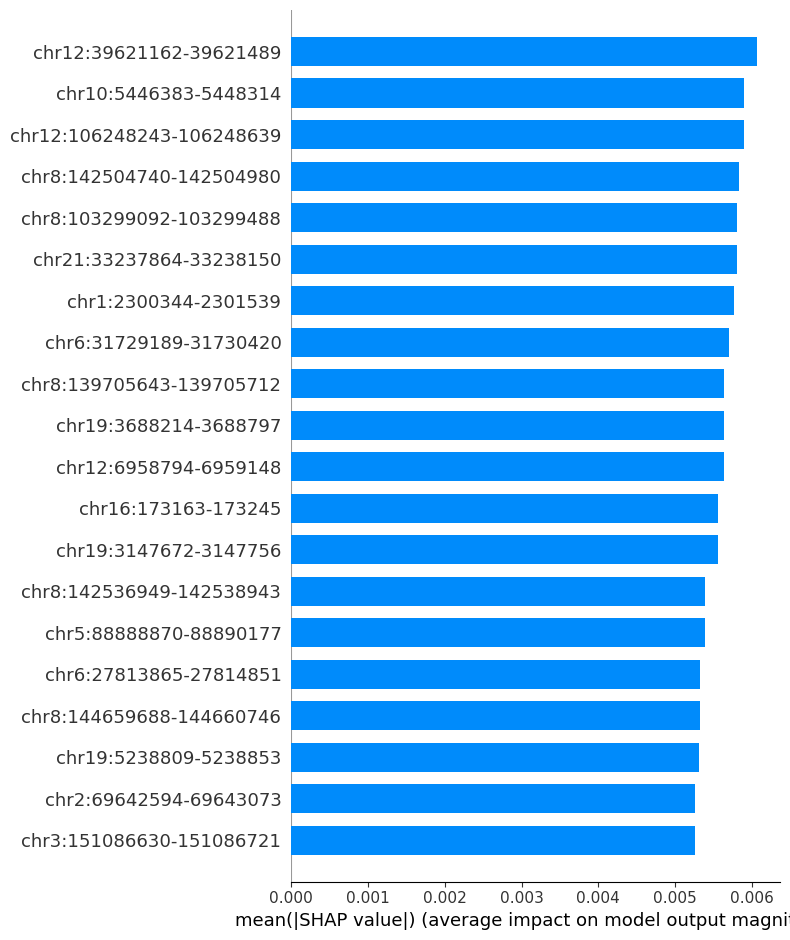

PCA after filtering:


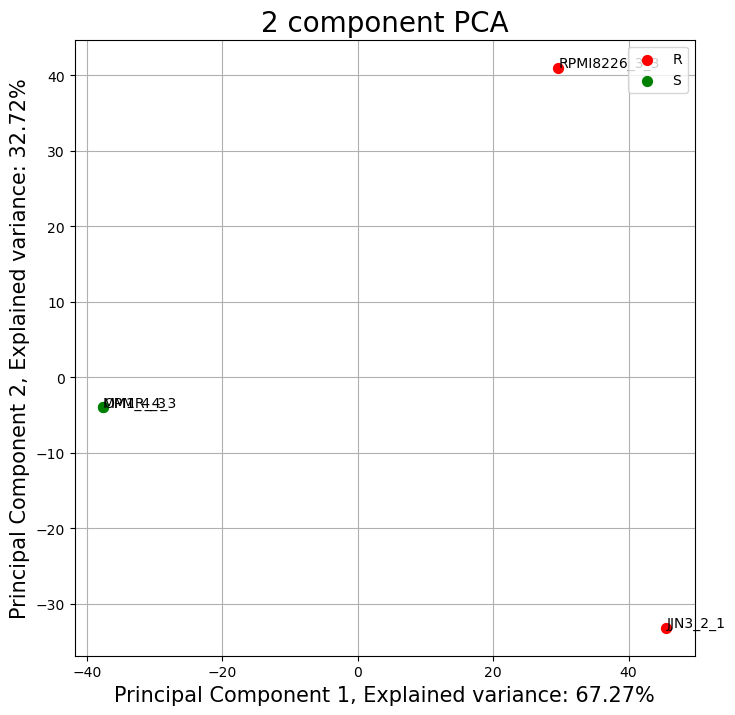

In [159]:
model, X_train, X_test, importances_df, shap_values = train_and_predict_single(meth_seg_wgbs_mm1_fm, test_size = 0.25, reg = True, dmr = "ttest")

In [132]:
train_and_predict_loo(meth_seg_wgbs_mm1_fm, reg = True, dmr = "ttest")

Average accuracy: 1.0
